In [2]:
!pip install google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 1.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.1 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install youtube-transcript-api

In [6]:
import re
import csv
import pandas as pd
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi

In [7]:
API_KEY = 'YOUR_API_KEY'

In [8]:
def get_video_id(url):
    # Extract Video id from the URL
    video_id_match = re.search(r'(?:v=|\/)([0-9A-Za-z_-]{11}).*', url)
    return video_id_match.group(1) if video_id_match else None

In [9]:
def get_video_title(video_id):
    # Build the youTube service
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    # Fetch the video details
    request = youtube.videos().list(
        part='snippet',
        id=video_id
    )
    response = request.execute()

    # Extract the title
    title = response['items'][0]['snippet']['title'] if response['items'] else 'Unknown Title'
    return title

In [11]:
def get_video_transcript(video_id):
    # Fetch the transcript
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return transcript
    except Exception as e:
        print(f"An Error Occurred: {e}")
        return []

In [12]:
def save_to_csv(title, transcript, filename):
    # Save the Title and Transcript to a CSV file
    transcript_data = [{'start': entry['start'], 'text': entry['text']} for entry in transcript]
    df = pd.DataFrame(transcript_data)
    df.to_csv(filename, index=False)

    # Save the Title separately
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Title:', title])

In [13]:
def main():
    url = input('Enter the YouTube Video Link: ')
    video_id = get_video_id(url)

    if not video_id:
        print('Invalid YouTube URL.')
        return

    title = get_video_title(video_id)
    transcript = get_video_transcript(video_id)

    if not transcript:
        print('No Transcript available for this video.')
        return

    filename = f"{video_id}_transcript.csv"
    save_to_csv(title, transcript, filename)
    print(f'Transcript Saved to {filename}')

if __name__ == '__main__':
    main()

Enter the YouTube Video Link: https://youtu.be/K6eB3V0JpVo?feature=shared
Transcript Saved to K6eB3V0JpVo_transcript.csv


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [16]:
# Load the Dataset
transcript_df = pd.read_csv("/Users/adityadubey/Video Chaptering using Python/K6eB3V0JpVo_transcript.csv")
print(transcript_df.head())

   start                                      text
0   4.08     hello everyone welcome back to Simply
1    6.2  learns YouTube channel today I'm talking
2  8.679      about something that could seriously
3  10.32      boost your career the top 10 digital
4  12.92     marketing certifications so if you're


In [17]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print("Dataset Overview:")
print(transcript_df.info())
print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   380 non-null    float64
 1   text    381 non-null    object 
dtypes: float64(1), object(1)
memory usage: 6.1+ KB
None

Basic Statistics:
            start
count  380.000000
mean   421.575100
std    237.285135
min      4.080000
25%    216.899750
50%    429.819500
75%    625.739250
max    833.279000


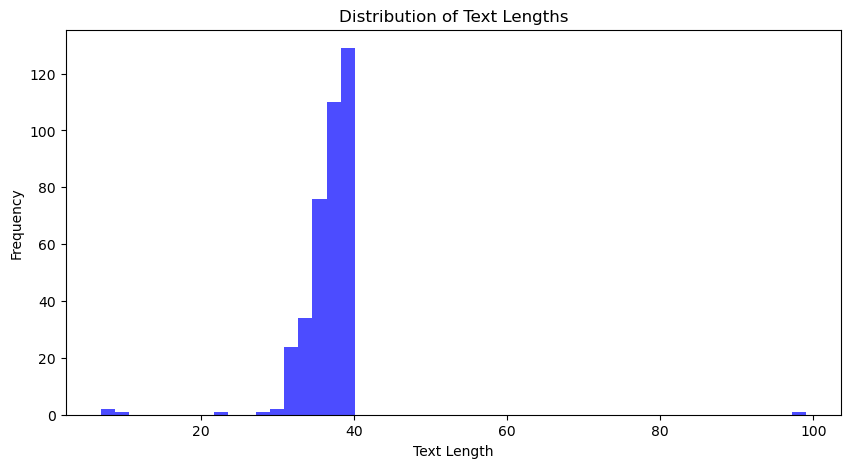

In [18]:
# Distribution of Text Lengths
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

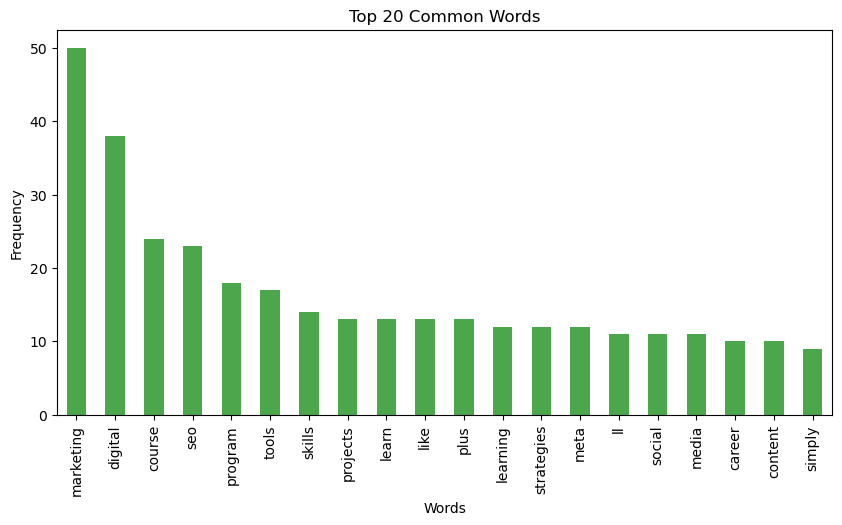

In [19]:
# Most Common Words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## Performing Topic Modelling on this dataset to Identify Key Topics and Transitions

In [20]:
# Topic Modeling using NMF
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: marketing digital certifications learning 10 courses analytics certified key 35
Topic 2: media social content like marketing strategies sem email creating advanced
Topic 3: plus studies case 20 35 10 howard learning capstone tools
Topic 4: course offers academy free ideal simply search marketing certification looking
Topic 5: seo technical page optimization email like content practical sem help
Topic 6: program covers designed career features best field job practical make
Topic 7: tools like ai generative offers latest semrush training chat google
Topic 8: meta professional certificate ll training list certified hands master provides
Topic 9: skills projects ll essential including ready showcase looking creation boost
Topic 10: learn simply experts collaboration youtube subscribe master generative job ranked


/Users/adityadubey/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [21]:
# Get Topic Distribution for each text segment
topic_distribution = nmf.transform(tf)

# Align the lengths by trimming the extra row in topic_distribution
topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

# Compute the dominant topic for each text segment
transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [22]:
# Analyze the content of each text segment to manually identify logical breaks
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [23]:
# Consolidate the logical breaks into broader chapters
threshold = 60  # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [24]:
# Merge consecutive breaks with the same dominant topic
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)  # Append the last chapter

In [25]:
# Convert the final chapters to a readable time format
chapter_points = []
chapter_names = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # Get the context for the chapter name
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')

    # Extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}: {chapter_name}")

# Display the final chapter points with names
print("\nFinal Chapter Points with Names:")
for time, name in zip(chapter_points, chapter_names):
    print(f"{time} - {name}")


Final Chapter Points with Names:
00:00:08 - Chapter 1: experts learn simply
00:01:09 - Chapter 2: case plus studies
00:02:11 - Chapter 3: experts learn simply
00:03:12 - Chapter 4: digital marketing program
00:04:12 - Chapter 5: ll projects skills
00:05:13 - Chapter 6: media social strategies
00:06:15 - Chapter 7: academy course courses
00:07:17 - Chapter 8: media social strategies
00:08:19 - Chapter 9: job learn simply
00:09:22 - Chapter 10: media social strategies
00:10:23 - Chapter 11: career click program
00:11:23 - Chapter 12: learn subscribe youtube
00:12:24 - Chapter 13: data domains skills
00:13:24 - Chapter 14: channel choose click


## Video chaptering is the process of dividing a video into distinct segments, each labelled with a specific title or chapter name, to enhance navigation and user experience.